In [1]:
%matplotlib inline

import wandb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sky_spot.utils import ClusterType

api = wandb.Api()

In [2]:
entity, project = "michaelvll", "sky-spot"  # set to your entity and project 
runs = api.runs(entity + "/" + project) 

In [3]:
PLOT_RUNS = [
    'strawman-trace-ddl=25.0-dur=20.0-over=0.2',
    'strawman-trace-ddl=20.0-dur=20.0-over=0.2',
    'strawman-trace-ddl=22.0-dur=20.0-over=0.2',
]


In [4]:
LINE_STYLES = ['-', '--', ':', '-.']
def plot_y(y_name='ClusterType', is_step_plot=True):
    fig, ax = plt.subplots()
    strategy, task_duration = None, None
    for i, run in enumerate(runs):
        if run.name not in PLOT_RUNS:
            continue
        df = run.history()
        if strategy is None:
            strategy = run.config['strategy']
            task_duration = run.config['task_duration_hours']
        else:
            assert strategy == run.config['strategy']
            assert task_duration == run.config['task_duration_hours']
        ddl = run.config['deadline_hours']
        drawstyle = 'steps-pre' if is_step_plot else None
        sns.lineplot(x=df['Elapsed'] / 3600, y=df[y_name], label=f'ddl={ddl}', linestyle=LINE_STYLES[i%len(LINE_STYLES)], drawstyle=drawstyle, ax=ax)
    ax.legend(loc='best')
    return ax, strategy, task_duration

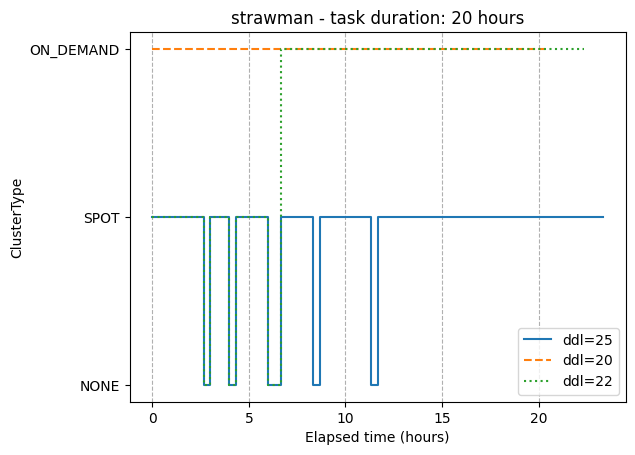

In [5]:
ax, strategy, task_duration = plot_y(y_name='ClusterType')
ax.set_xlabel('Elapsed time (hours)')
ax.set_yticks([1, 2, 3])
ax.set_yticklabels([ClusterType(i).name for i in [1, 2, 3]])
ax.set_title(f'{strategy} - task duration: {task_duration} hours')
ax.grid(True, which='major', axis='x', linestyle='--')

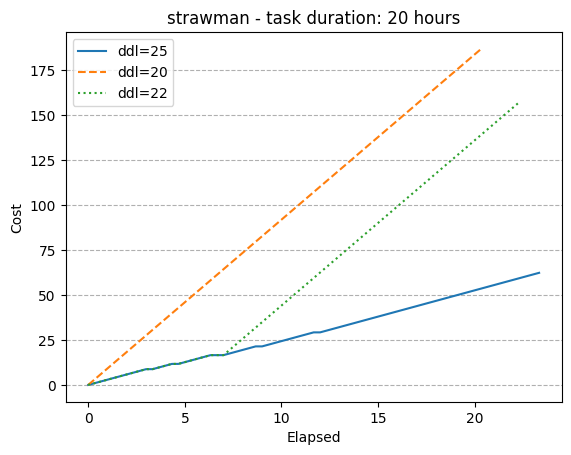

In [6]:
ax, strategy, task_duration = plot_y(y_name='Cost', is_step_plot=False)
ax.set_title(f'{strategy} - task duration: {task_duration} hours')
ax.grid(True, which='major', axis='y', linestyle='--')

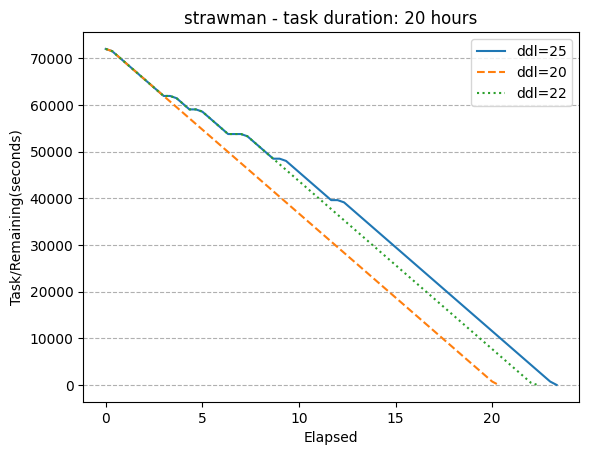

In [7]:
ax, strategy, task_duration = plot_y(y_name='Task/Remaining(seconds)', is_step_plot=False)
ax.set_title(f'{strategy} - task duration: {task_duration} hours')
ax.grid(True, which='major', axis='y', linestyle='--')